Training process of Machine Learning Model

In [1]:
import sys 
sys.path.append("../../")

In [2]:
import pandas
import xgboost as xgb
import numpy
from calibration import calibrators, plots
from sklearn.model_selection import train_test_split

Loading Datasets

In [3]:
training_set = pandas.read_csv("../../data/processed_data/training_set.csv")
validation_set = pandas.read_csv("../../data/processed_data/validation_set.csv")
testing_set = pandas.read_csv("../../data/processed_data/testing_set.csv")
calibration_set = pandas.read_csv("../../data/processed_data/calibration_set.csv")

Splitting Calibration set

In [4]:
X, Y = calibration_set.drop(columns=['bad_client']), calibration_set['bad_client']
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=100
)

train_calibration_set = pandas.concat([x_train, y_train], axis=1)
test_calibration_set = pandas.concat([x_test, y_test], axis=1)

Creating Baseline Model

In [5]:
model = xgb.XGBClassifier()

In [6]:
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate 

Initial Comparison

In [7]:
x_train = training_set.drop(columns=['bad_client'])
y_train = training_set['bad_client']

loss_function = make_scorer(log_loss, greater_is_better=False)

cv_results = cross_validate(
    estimator=model,
    X=x_train,
    y=y_train,
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=10),
    scoring=loss_function
)
# Checking model training loss
cv_score = numpy.mean(cv_results['test_score'])
print('loss: %s' % cv_score)


loss: -0.227754351353828


Fine Tuning the Model

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, log_loss

In [9]:
hyperparams = {
}

X_validation = validation_set.drop(columns=['bad_client'], inplace=False)
Y_validation = validation_set['bad_client']

loss_function = make_scorer(log_loss, greater_is_better=False)
tuned_model = GridSearchCV(
    estimator=model,
    param_grid=hyperparams,
    scoring=loss_function,
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5)
)
# Fitting model
tuned_model.fit(X_validation, Y_validation)
chosen_model = tuned_model.best_estimator_
loss = tuned_model.best_score_
print('hyperparameter validation loss: %s' % loss)

hyperparameter validation loss: -0.2118484400095891


In [10]:
x_train_calibration = train_calibration_set.drop(columns=['bad_client'])
y_train_calibration_proba = pandas.Series(chosen_model.predict_proba(x_train_calibration)[:, 1])

Checking Calibration quality of the Model

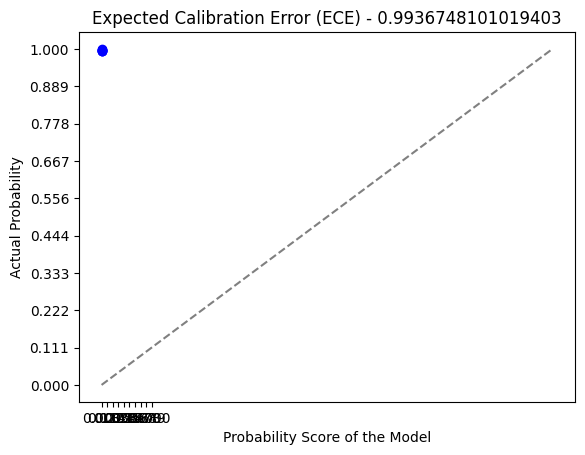

In [11]:
plots.calibration_plot(
    y_true=train_calibration_set['bad_client'],
    y_pred=y_train_calibration_proba,
    bins=7,
)

Creating Training Calibration Dataset

In [12]:
calibration_train_dataset = calibrators.CalibrationDataset(
    decision_scores=y_train_calibration_proba.to_numpy().tolist(),
    true_classes=train_calibration_set['bad_client'].to_numpy().tolist()
)

Training Calibration Dataset

In [13]:
platt_scaler = calibrators.PlattScaling()

# training calibration algorithm
platt_scaler.train(
    train_dataset=calibration_train_dataset
)

Creating Testing Calibration Dataset

In [14]:
# extracting decision scores from given testing calibration data
x_test_calibration = test_calibration_set.drop(columns=['bad_client'])
predicted_test_calibration_scores = chosen_model.predict_proba(x_test_calibration)[:, 1]

In [15]:
# creating calibration dataset

calibration_test_dataset = calibrators.CalibrationDataset(
    decision_scores=predicted_test_calibration_scores.tolist(),
    true_classes=test_calibration_set['bad_client'].to_numpy().tolist()
)

Estimating Calibration Algorihtm

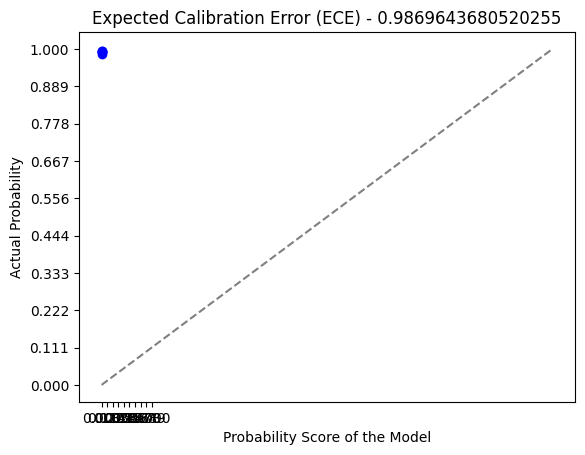

In [16]:
true_classes = pandas.Series(calibration_test_dataset.true_classes)
predicted_probs = pandas.Series(platt_scaler.get_calibrated_prob(
    decision_scores=calibration_test_dataset.decision_scores
))

plots.calibration_plot(
    y_true=true_classes,
    y_pred=predicted_probs,
    bins=5,
)

In [17]:
predicted_probs

0      0.003884
1      0.003884
2      0.003884
3      0.003889
4      0.003884
         ...   
980    0.003884
981    0.003889
982    0.003898
983    0.003884
984    0.003886
Length: 985, dtype: float64

Testing ML model on a Testing set

In [18]:
from sklearn.metrics import f1_score

In [21]:
X_test = testing_set.drop(columns=['bad_client'])
Y_test = testing_set['bad_client']

def eval_f1_macro(y_true, y_pred):
    """
    Standard F1 Score metric with weighted average
    """
    return f1_score(
        y_true, y_pred,
        average='macro'
    )

eval_function = make_scorer(eval_f1_macro, greater_is_better=True)

cv_results = cross_validate(
    estimator=chosen_model,
    X=X_test,
    y=Y_test,
    cv=StratifiedKFold(n_splits=5),
    scoring=eval_function,
    n_jobs=-1
)
print('F1 Score: %s' % numpy.mean(cv_results['test_score']))

F1 Score: 0.6162267829005293


Saving model

In [22]:
import pickle

In [23]:
pickle.dump(chosen_model, open('../models/classifier.pkl', mode='wb'))

Saving Calibration Model

In [24]:
pickle.dump(platt_scaler, open("../calibrators/platt_calibrator.pkl", mode='wb'))